In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

np.random.seed(42)
tf.random.set_seed(42)

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
tf.__version__, keras.__version__

('2.0.0', '2.2.4-tf')

In [3]:
print("GPU is", "AVAILABLE." if tf.config.experimental.list_physical_devices('GPU')else "NOT AVAILABLE.")

GPU is AVAILABLE.


# 1. 卷积神经网络 (convolutional neural network, convnet) 简介

In [4]:
# Load the MNIST data
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

In [5]:
train_images.dtype, train_labels.dtype

(dtype('uint8'), dtype('uint8'))

In [6]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [7]:
# Preprocess the data
from tensorflow.keras.utils import to_categorical

train_images = train_images.reshape((60000, 28*28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28*28))
test_images = test_images.astype('float32') / 255

# Converts a class vector (integers) to binary class matrix.
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [8]:
test_labels

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
# Train a FC model on MNIST images
tf.keras.backend.clear_session()
fc_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(28*28, )),
    tf.keras.layers.Dense(10, activation='softmax')
])

fc_model.compile(optimizer='rmsprop',
                 loss='categorical_crossentropy',
                 metrics=['acc'])
fc_model.fit(train_images, train_labels, epochs=5, batch_size=64)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 96us/sample - loss: 0.2212 - acc: 0.9345
Epoch 2/5
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0907 - acc: 0.9723
Epoch 3/5
60000/60000 [==============================] - 4s 75us/sample - loss: 0.0608 - acc: 0.9817
Epoch 4/5
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0455 - acc: 0.9866
Epoch 5/5
60000/60000 [==============================] - 4s 66us/sample - loss: 0.0344 - acc: 0.9898


In [10]:
fc_model.evaluate(test_images, test_labels, verbose=0)

[0.0775108371532784, 0.9791]

Ovefitting!

In [11]:
# A small convnet
tf.keras.backend.clear_session()
small_convnet = tf.keras.Sequential([
    # When using Conv2D as the first layer in a model,
    # provide the keyword argument input_shape
    # (tuple of integers, does not include the sample axis),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
])
small_convnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


convnet 接受 shape 为 `(image_height, image_width, image_channels)` 的输入张量（不包括 sample 轴，且 channel_last）。

每个 `Conv2D` 层和 `MaxPooling2D` 层的输出都是一个形状为 `(height, width, channels)` 的 3D 张量。

**width 和 height 两个维度的尺寸通常会随着网络加深而变小**。

channels 数量由传入 `Conv2D` 层的第一个参数 (`filters`) 所控制 (32 或 64)。

In [12]:
# Add a classifier on top of the convnet
# Flattens the input. Does not affect the batch size.
small_convnet.add(tf.keras.layers.Flatten())
small_convnet.add(tf.keras.layers.Dense(64, activation='relu'))
small_convnet.add(tf.keras.layers.Dense(10, activation='softmax'))

small_convnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [13]:
# Load and preprocess the data
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

# Train the convnet on MNIST images
small_convnet.compile(optimizer='rmsprop',
                      # loss='categorical_crossentropy',
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'])
small_convnet.fit(train_images, train_labels, epochs=5, batch_size=64)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 10s 163us/sample - loss: 0.1751 - acc: 0.9466
Epoch 2/5
60000/60000 [==============================] - 6s 101us/sample - loss: 0.0463 - acc: 0.9851
Epoch 3/5
60000/60000 [==============================] - 6s 102us/sample - loss: 0.0316 - acc: 0.9903
Epoch 4/5
60000/60000 [==============================] - 6s 99us/sample - loss: 0.0245 - acc: 0.9923
Epoch 5/5
60000/60000 [==============================] - 6s 103us/sample - loss: 0.0196 - acc: 0.9942


In [14]:
test_loss, test_acc = small_convnet.evaluate(test_images, test_labels, verbose=0)
test_acc

0.992

有提升哦。

## 1.1 卷积运算 (The convolutional operation)

**<font color='crimson'>Dense 层和 convolution 层的根本区别在于：Dense 层从输入特征空间中学到的是全局模式</font>** (如 MNIST 图片中所有像素的模式)，**<font color='crimson'>而 convolution 层学到的是局部模式。</font>** 对于图像来说，学到的就是输入图像的二维小窗口中发现的模式。

这个重要特性使 convnet 具有以下两个有趣的性质。

- **<font color='blue'>convnet 学到的模式具有平移不变性 (translation invariant)。</font>** <font color='blue'>convnet 在图像右下角学到某个模式之后，它可以在任何地方识别这个模式</font>，比如左上角。<font color='blue'>对于 DCN 来说，如果模式出现在新的位置，它只能重新学习这个模式</font>。<font color='crimson'>这使得 convnet 在处理图像时可以高效利用数据 (因为视觉世界从根本上具有平移不变性)，它只需要更少的训练样本就可以学到具有泛化能力的数据表示。</font>


- **<font color='blue'>convnet 可以学到模式的空间层次结构 (spatial hierarchies of patterns)。</font>** <font color='blue'>第一个卷积层将学习较小的局部模式 (比如边缘)，第二个卷积层将学习由第一层特征组成的更大的模式，以此类推</font>。<font color='crimson'>这使得 convnet 可以有效地学习越来越复杂、越来越抽象的视觉概念 (因为视觉世界从根本上具有空间层次结构)。</font>

![空间层次结构](figs/chap05-figs/a-spatial-hierarchy-of-visual-modules.png)

<br>

对于包含两个空间轴 (height 和 width) 和一个 depth 轴 (也叫通道轴 channels axis) 的 3D 张量，其卷积也叫**<font color='blue'>特征图 (feature map)</font>**。

- 对于 RGB 图像，深度轴的维度大小等于 3，因为图像有 3 个颜色通道: 红色、绿色和蓝色。

- 对于黑白图像 (比如 MNIST 数字图像)，深度等于 1 (表示灰度等级)。


**<font color='crimson'>卷积运算从输入特征图中提取图块，并对所有这些图块应用相同的变换，生成输出特征图 (output feature map)。该输出特征图仍是一个 3D 张量，具有宽度和高度，其深度可以任意取值，因为输出深度是层的参数，深度轴的不同通道不再像 RGB 输入那样代表特定颜色，而是代表过滤器。</font>** **<font color='blue'>过滤器 (filter)</font>** 对输入数据的某一方面进行编码，比如，单个过滤器可以从更高层次编码这样一个概念：“输入中包含一张脸。”

<font color='crimson'>在 MNIST 中，第一个卷积层接收一个大小为 `(28, 28, 1)` 的特征图，并输出一个大小为 `(26, 26, 1)` 的特征图，即它在输入上计算 32 个过滤器。对于这 32 个 output channel，每个 channel 都包含一个 26x26 的数值网格，它是 filter 对输入的响应图 (response map)，表示这个 filter 模式在输入中不同位置的响应。</font>这也是特征图的含义：**<font color='blue'>深度轴 (depth axis) 的每个维度都是一个特征 (或 filter)，而 2D 张量 `output[:, :, n]` 是这个 filter 在输入上响应的二维空间图 (map)。</font>**

![特征图](figs/chap05-figs/response-map.png)

<br>

**<font color='blue'>卷积由以下两个关键参数所定义。</font>**

- <font color='blue'>从输入中提取的图块 (patches) 尺寸。</font>这些图块的大小通常是 3×3 或 5×5。


- <font color='blue'>输出特征图的深度。</font>卷积所计算的过滤器的数量。

`tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3))  # my parameters`

<br>

<div class="alert alert-block alert-info">
    <b><center>卷积的工作原理</center></b><br>
在 3D 输入特征图上滑动 (slide) 3×3 或 5×5 的窗口，在每个可能的位置停止并提取周围特征的 3D 图块 [形状为 (window_height, window_width, input_ depth)]。然后每个 3D 图块与学到的同一个权重矩阵 [<b><font color='red'>卷积核 (convolution kernel)</font></b>] 做张量积，转换成形状为 `(output_depth, )` 的 1D 向量。然后对所有这些向量进行空间重组，使其转换为形状为 `(height, width, output_depth)` 的 3D 输出特征图。输出特征图中的每个空间位置都对应于输入特征图中的相同位置 (比如输出的右下角包含了输入右下角的信息)。举个例子，利用 3×3 的窗口，向量 `output[i, j, :]` 来自 3D 图块 `input[i-1:i+1, j-1:j+1, :]`。整个过程如下。
</div>

![卷积的工作原理](fig/chap05-figs/convolution.png)

**<font color='blue'>输出的宽度和高度可能与输入的宽度和高度不同。不同的原因可能有两点：</font>**

- <font color='blue'>边界效应 (border effects)，可以通过对输入特征图进行填充来抵消</font>

  如果希望输出特征图的空间维度与输入相同，那么可以使用填充 (padding) 。<font color='crimson'>填充是在输入特征图的每一边添加适当数目的行和列，使得每个输入方块都能作为卷积窗口的中心。</font>对于 3×3 的窗口，在左右各添加一列，在上下各添加一行。对于 5×5 的窗口，各添加两行和两列。

  `tf.keras.layers.Conv2d(..., padding='valid', ...)  # Default` 表示不使用填充 (只使用有效的窗口位置)，`'same'`表示填充后输出的 width 和 height 与输入相同。


  - <font color='blue'>使用了步幅 (stride)</font>

  两个连续 3x3 或 5x5 窗口的距离是卷积的一个参数，叫作**<font color='red'>步幅 (stride)</font>**，默认值为 1。也可以使用**<font color='red'>步进卷积 (strided convolution)</font>**，即步幅大于 1 的卷积。
  
  **`stride=2` 意味着特征图的 width 和 height 都被做了 2 倍下采样 (除了边界效应引起的变化)。**
  
  <font color='crimson'>虽然步进卷积对某些类型的模型可能有用，但在实践中很少使用。熟悉这个概念是有好处的。为了对特征图进行下采样，我们不用步幅，而是通常使用最大池化 (max-pooling) 运算。</font>


![valid padding](figs/chap05-figs/valid-padding.png)

![same padding](figs/chap05-figs/same-padding.png)

![same padding](figs/chap05-figs/stride.png)


## 1.2 最大池化运算 (The max-pooling operation)

<div class="alert alert-block alert-info">
    <b>max pooling 的作用：对特征图进行下采样 (downsample)，与步进卷积类型。</b><br>
    
<b>max pooling 是从输入特征图中提取窗口，并输出每个 channel 的最大值。</b>它的概念与卷积类似，但是<b>最大池化使用硬编码的 max 张量运算对局部图块进行变换，而不是使用学到的线性变换 (卷积核)</b>。
</div>

**<font color='crimson'>最大池化与卷积的最大不同之处在于，最大池化通常使用 2×2 的窗口和步幅 2，其目的是将特征图下采样 2 倍。与此相对的是，卷积通常使用 3×3 窗口和步幅 1。</font>**

In [15]:
tf.keras.backend.clear_session()
model_no_max_pooling = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
])
model_no_max_pooling.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


<div class="alert alert-block alert-info">
    <b><center>为什么要 downsample ？</center></b><br>

1. 上面这种架构不利于学习特征的空间层次结构 (a spatial hierarchy)。第 3 层的 3x3 窗口只包含初始输入图像的 7x7 窗口中包含的信息。 convnet 学到的高级模式相对于初始输入来说仍然很小，这可能不足以解决任务 (没学到足够的信息)。<b>需要让最后一个卷积层的特征包含输入的整体信息。</b>


2. 最后一层的特征图对于 sample 来说共有 22x22x64=30976 个元素。太多了！如果你将其 展平并在上面添加一个大小为 512 的 Dense 层，那一层将会有 1580 万个参数。这对于这样一个小模型来说太多了，会导致严重的过拟合。<br>

<b><font color='crimson'>使用 downsample 的原因在于：一、减少需要处理的特征图的元素个数；二是通过让连续卷积层的窗口越来越大 (即窗口覆盖原始输入的比例越来越大)，从而引入空间过滤器的层级结构。</font></b>
    
</div>

**<font color='blue'>max pooling 不是实现 downsample 的唯一方法。其他方法有:</font>**

- 在卷积层中使用 stride 来实现；


- 使用 mean pooling 来代替 max pooling，其方法是将每个局部输入图块变换为取该图块各 channel 的平均值，而不是最大值。

<div class="alert alert-block alert-info">
    <b><center>为什么 downsample 要采用 max pooling ?</center></b><br>

<b><font color='blue'>max pooling 的效果往往比这些替代方法更好。原因在于特征中往往编码了某种模式或概念在特征图的不同位置是否存在 (因此得名特征图)，而观察不同特征的 max 而不是 mean 能够给出更多的信息。</font></b><br><br>
    
因此，<b><font color='crimson'>最合理的 subsample 策略是首先生成密集的特征图 (通过无步进的卷积)，然后观察特征每个小图块上的最大激活， 而不是查看输入的稀疏窗口 (通过步进卷积)或对输入图块取平均，因为后两种方法可能导致错过或淡化特征是否存在的信息。</font></b>
</div>

# 2. 在小数据集上从头训练一个 convnet

数据集很小，经常会遇到。**“很小的”样本可能是几百张图像，也可能是几万张图像。**

这里，数据集中包含 4000 张猫和狗的图像 (2000 张猫的图像，2000 张狗的图像)。将 2000 张图像用于训练，1000 张用于验证，1000 张用于测试。

在 2000 个训练样本上训练一个简单的小型卷积神经网络，不做任何正则化，为模型目标设定一个基准。然后使用数据增强。

解决小数据集的方法：

- 从头训练一个 NN (**这里**)


- [使用预训练的 NN 做特征提取]()


- [对预训练的 NN 进行微调]()

**<font color='crimson'>DL 的一个基本特性就是能够独立地在训练数据中找到有趣的特征，无须人为的特征工程，而这只在拥有大量训练样本时才能实现。对于输入样本的维度非常高 (比如图像) 的问题尤其如此。</font>**

<font color='blue'>“大量”样本是相对的，即相对于你所要训练网络的大小和深度而言。</font>只用几十个样本训练 convnet 就解决一个复杂问题是不可能的，但如果模型很小，并做了很好的正则化，同时任务非常简单，那么几百个样本可能就足够了。

<font color='blue'>由于 convnet 学到的是局部的、平移不变的特征，它对于感知问题可以高效地利用数据。</font>虽然数据相对较少，但在非常小的图像数据集上从头开始训练一个 convnet，仍然可以得到不错的结果，而且无须任何自定义的特征工程。

<font color='crimson'>DL 模型本质上具有高度的可复用性</font>，比如，已有一个在大规模数据集上训练的图像分类模型或语音转文本模型，你只需做很小的修改就能将其复用于完全不同的问题。特别是在 cv 领域。

In [16]:
import shutil

In [17]:
# Generate data
original_dataset_dir = '/home/libing/datasets/dogs_vs_cats'
base_dir = '/home/libing/datasets/dogs_vs_cats_small'
os.mkdir(base_dir)  # Store the smaller dataset

# Directories for training, validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# Directory with test cat/dog pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [18]:
len(os.listdir(train_cats_dir)), len(os.listdir(validation_cats_dir)), len(os.listdir(test_cats_dir))

(1000, 500, 500)

In [19]:
len(os.listdir(train_dogs_dir)), len(os.listdir(validation_dogs_dir)), len(os.listdir(test_dogs_dir))

(1000, 500, 500)

<div class="alert alert-block alert-info">
    <b>增加 Conv2D+MaxPool2D 组合，既可以增大 NN 容量，也可以进一步减小特征图尺寸，使其在连接 Flatten 层不会有太多参数。</b><br>
    <b>网络中特征图的深度在逐渐增大 (从 32 增大到 128)，而特征图的尺寸在逐渐减小 (从 150×150 减小到 7×7)。这几乎是所有 convnet 的模式。</b>
</div>

In [20]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    # When using Conv2D as the first layer in a model,
    # provide the keyword argument input_shape
    # (tuple of integers, does not include the sample axis),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [21]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

<font color='crimson'>数据以 JPEG 形式存储在硬盘中，数据预处理步骤如下：</font>

1. 读取图像文件
2. 将 JPEG 文件解码为 RGB 像素网格
3. 将这些像素网格转换为浮点数张量
4. 将像素值 (0~255) 缩放到 [0, 1] 之间 (NN 喜欢处理较小的输入值)

In [22]:
from tensorflow.keras.preprocessing import image

In [23]:
# rescale: rescaling factor. Defaults to None.
# If None or 0, no rescaling is applied,
# otherwise we multiply the data by the value provided (after applying all other transformations).
train_datagen = image.ImageDataGenerator(rescale=1/255.)
val_datagen = image.ImageDataGenerator(rescale=1/255.)

# Default color_mode='rgb', shuffle=True
train_gen = train_datagen.flow_from_directory(
    train_dir,
    # All images will resized to 150x150. Defaults to (256, 256)
    target_size=(150, 150),
    batch_size=32,
    # Since I use binary_crossentropy loss
    class_mode='binary')
val_gen = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [24]:
for data_batch, labels_batch in train_gen:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    print('labels batch:', labels_batch)
    break

data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)
labels batch: [1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 0. 0. 0. 0. 0.]


利用 Python generator，可以使用 **`fit_generator`** 方法让模型拟合数据，效果和 `fit` 相同。

其第 1 个参数应该是 Python generator，可以不停地生成输入和目标组成的 batch。<font color='crimson'>因为数据是不断生成的，所以模型需要知道每个 epoch 需要从 generator 中抽取多少个样本。这是 `steps_per_epoch` 的作用：从 generator 中抽取 `steps_per_epoch` 个 batch 后（即运行了 `steps_per_epoch` 次梯度下降），拟合过程将进入下一个 epoch。</font>

训练过程中也可以传入 **`validation_data`**。这个参数可以是一个 **Python generator**，也可以是 NumPy 数组组成的元组。如果传入一个 Python generator，那么这个 generator **可以不停地生成验证数据 batch，因此需要指定 validation_steps 参数，说明需要从验证 generator 中抽取多少个 batch 用以评估**。

In [25]:
#  It will be removed in a future version.
# Instructions for updating: Please use `Model.fit`, which supports generators.
history = model.fit_generator(
    train_gen,
    epochs=30,
    steps_per_epoch=2000/32+1,
    validation_data=val_gen,
    validation_steps=1000/32+1)

Epoch 1/30
64/63 [==============================] - 13s 197ms/step - loss: 0.6912 - acc: 0.5207 - val_loss: 0.6926 - val_acc: 0.6192
Epoch 2/30
64/63 [==============================] - 12s 188ms/step - loss: 0.6636 - acc: 0.6048 - val_loss: 0.6627 - val_acc: 0.6318
Epoch 3/30
64/63 [==============================] - 11s 168ms/step - loss: 0.6260 - acc: 0.6506 - val_loss: 0.6703 - val_acc: 0.5998
Epoch 4/30
64/63 [==============================] - 12s 182ms/step - loss: 0.5866 - acc: 0.6737 - val_loss: 0.6253 - val_acc: 0.6570
Epoch 5/30
64/63 [==============================] - 12s 180ms/step - loss: 0.5596 - acc: 0.7067 - val_loss: 0.5986 - val_acc: 0.6715
Epoch 6/30
64/63 [==============================] - 11s 173ms/step - loss: 0.5334 - acc: 0.7328 - val_loss: 0.5751 - val_acc: 0.6967
Epoch 7/30
64/63 [==============================] - 11s 175ms/step - loss: 0.5164 - acc: 0.7525 - val_loss: 0.5588 - val_acc: 0.7035
Epoch 8/30
64/63 [==============================] - 11s 177ms/step - 

In [26]:
# It is good practice to always to save the model after training.
model.save('models/chap05-models/cats_and_dogs_small_1.h5')

In [27]:
def plot_history(history):
    history_dict = history.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']

    epochs = [i + 1 for i in history.epoch]

    # Plot the results
    plt.figure(figsize=(14, 4.2))
    plt.subplot(121)
    plt.plot(epochs, loss_values, 'c+-', label='Training loss')
    plt.plot(epochs, val_loss_values, 'm.-', label='Val loss')
    plt.xlabel('Epochs', fontsize=12)
    plt.xticks(epochs, rotation=90)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=18)
    plt.title('Training and validation loss', fontsize=16)

    plt.subplot(122)
    plt.plot(epochs, acc, 'c+-', label='Training acc')
    plt.plot(epochs, val_acc, 'm.-', label='Val acc')
    plt.xlabel('Epochs', fontsize=12)
    plt.xticks(epochs, rotation=90)
    plt.ylabel('Acc', fontsize=12)
    plt.legend(fontsize=18)
    plt.title('Training and validation acc', fontsize=16)

    plt.show()

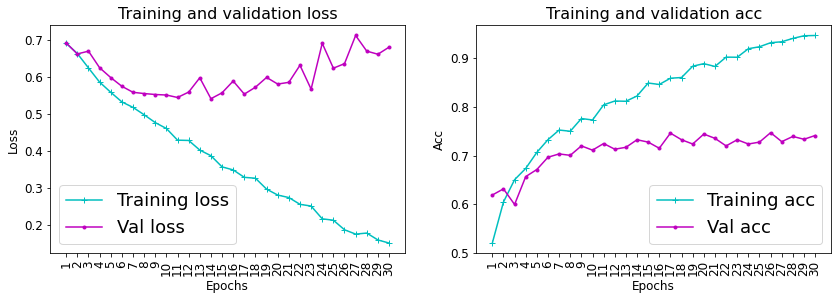

In [28]:
plot_history(history)

很明显过拟合！

## 2.1 数据增强 (data augmentation)

因为数据样本较少，过拟合是关心的重点。在 CV 中几乎都会用到数据增强来解决过拟合。

<div class="alert alert-block alert-info">
    <b><center><font color='crimson'>数据增强 (data augmentation)</font></center></b><br>
    从现有的训练样本中生成更多的训练数据，其<b>方法是利用多种能够生成可信图像的随机变换来增加 (argment) 样本</b>。<br><br>
    <b>目标是模型在训练时不会两次查看完全相同的图像。</b>这让模型能够观察到数据的更多内容，从而具有更好的泛化能力。
</div>

In [29]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,       # 随机旋转的角度范围
    width_shift_range=0.2,   # 在水平方向平移的范围 (相对于 width)
    height_shift_range=0.2,  # 在垂直方向平移的范围 (相对于 height)
    shear_range=0.2,         # 随机错切的角度
    zoom_range=0.2,          # 随机缩放的范围
    horizontal_flip=True,    # 将一半图像水平翻转
    fill_mode='nearest')

每个参数的效果见[这里]()。

In [30]:
a_cat_image_path = os.path.join(train_cats_dir, os.listdir(train_cats_dir)[0])
a_cat_image_path

'/home/libing/datasets/dogs_vs_cats_small/train/cats/cat.542.jpg'

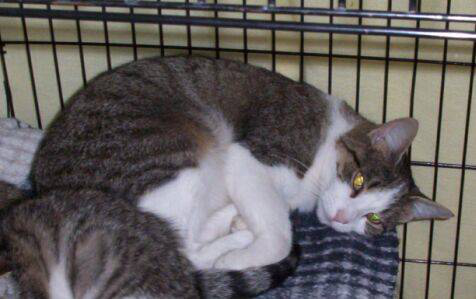

In [31]:
image.load_img(a_cat_image_path)

In [32]:
# Loads an image into PIL format.
img = image.load_img(a_cat_image_path, target_size=(150, 150))
# Converts a PIL Image instance to a Numpy array.
x = image.img_to_array(img)
x = x.reshape((1, ) + x.shape)  # (1, 150, 150, 3)

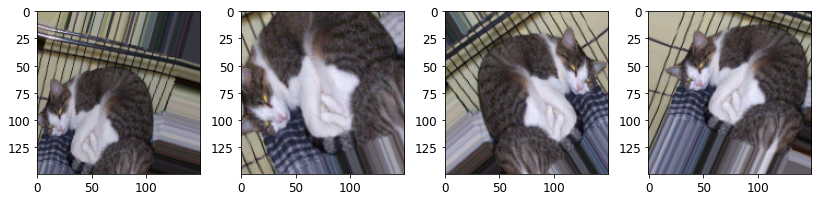

In [33]:
i = 0
plt.figure(figsize=(14, 3))
for batch_arr in datagen.flow(x, batch_size=1):
    plt.subplot(1, 4, i+1)
    plt.imshow(image.array_to_img(batch_arr[0]))
    i += 1
    if i == 4:
        break
    

<font color='crimson'>如果你使用这种数据增强来训练一个新网络，那么网络将不会两次看到同样的输入。但网络看到的输入仍然是高度相关的，因为这些输入都来自于少量的原始图像。你无法生成新信息，而只能混合现有信息。因此，这种方法可能不足以完全消除过拟合。</font>为了进一步降低过拟合，你还需要向模型中添加一个 `Dropout` 层，添加到密集连接分类器之前。

In [36]:
# 增加 Conv2D+MaxPooling2D 的组合，既可以增大网络容量，也可以进一步减小特征图尺寸
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),  # 进一步降低过拟合
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

In [37]:
# Train the convnet using data augmentation and dropout
train_gen = image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# The validation and test data should NOT be augmented!
test_gen = image.ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')
val_generator = test_gen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

history = model.fit_generator(
    train_generator,
    epochs=100,
    steps_per_epoch=100,
    validation_data=val_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 37s 367ms/step - loss: 0.6916 - acc: 0.5311 - val_loss: 0.6782 - val_acc: 0.6104
Epoch 2/100
100/100 [==============================] - 27s 273ms/step - loss: 0.6783 - acc: 0.5824 - val_loss: 0.6582 - val_acc: 0.6168
Epoch 3/100
100/100 [==============================] - 27s 272ms/step - loss: 0.6598 - acc: 0.5972 - val_loss: 0.6363 - val_acc: 0.6390
Epoch 4/100
100/100 [==============================] - 30s 298ms/step - loss: 0.6488 - acc: 0.6269 - val_loss: 0.6247 - val_acc: 0.6396
Epoch 5/100
100/100 [==============================] - 29s 287ms/step - loss: 0.6399 - acc: 0.6310 - val_loss: 0.6041 - val_acc: 0.6694
Epoch 6/100
100/100 [==============================] - 30s 302ms/step - loss: 0.6204 - acc: 0.6496 - val_loss: 0.5808 - val_acc: 0.6929
Epoch 7/100
100/100 [==============================] - 30s 299ms/step - loss: 0.6051 - acc: 0.6658 -

100/100 [==============================] - 29s 285ms/step - loss: 0.4231 - acc: 0.8037 - val_loss: 0.4809 - val_acc: 0.7900
Epoch 61/100
100/100 [==============================] - 29s 285ms/step - loss: 0.4123 - acc: 0.8081 - val_loss: 0.4136 - val_acc: 0.8058
Epoch 62/100
100/100 [==============================] - 29s 294ms/step - loss: 0.4109 - acc: 0.8169 - val_loss: 0.4482 - val_acc: 0.7925
Epoch 63/100
100/100 [==============================] - 29s 294ms/step - loss: 0.4073 - acc: 0.8128 - val_loss: 0.4320 - val_acc: 0.7944
Epoch 64/100
100/100 [==============================] - 30s 300ms/step - loss: 0.3927 - acc: 0.8163 - val_loss: 0.4451 - val_acc: 0.7970
Epoch 65/100
100/100 [==============================] - 30s 297ms/step - loss: 0.4145 - acc: 0.8103 - val_loss: 0.4522 - val_acc: 0.7881
Epoch 66/100
100/100 [==============================] - 30s 302ms/step - loss: 0.4035 - acc: 0.8153 - val_loss: 0.4527 - val_acc: 0.7931
Epoch 67/100
100/100 [==============================] 

In [41]:
# Save the model
model.save('models/chap05-models/cats_and_dogs_small_2.h5')

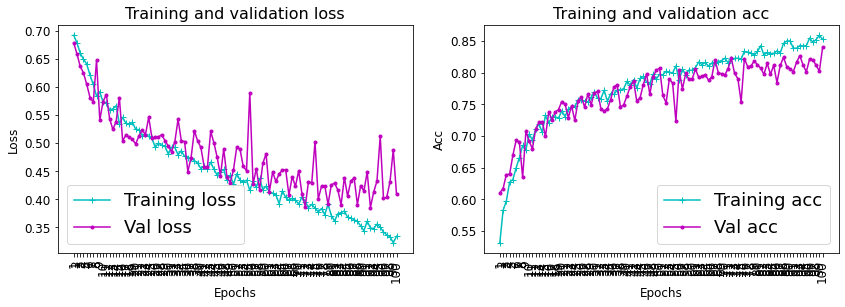

In [42]:
plot_history(history)

使用了 data augmentation 和 dropout 之后，模型基本不再过拟合：the training curves are rather closely tracking the validation curves.

可以通过正则化方法以及调节 NN 参数，可以得到 86%/87% 的精度。但是只靠从头开始训练自己的 convnet，再想提高精度就十分困难了，因为可用的数据太少。